# Прогнозирование отношения доллара к евро

## Подключение библиотек

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
    rc = {
        'figure.figsize': (16, 9),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## 1 Датасет

### 1.1 Анализ и преобразование данных

In [2]:
os.listdir('data')

['ECB_FX_USD-quote.csv', 'euro-dollar-exchange-rate-historical-chart.csv']

Датасет взят отсюда: https://data.humdata.org/dataset/ecb-fx-rates?force_layout=desktop

In [3]:
df = pd.read_csv('data/ECB_FX_USD-quote.csv')
df.head()

,Date,EUR,JPY,BGN,CZK,DKK,GBP,HUF,PLN,RON,...,ILS,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR
0,#date,#value+eur,#value+jpy,#value+bgn,#value+czk,#value+dkk,#value+gbp,#value+huf,#value+pln,#value+ron,...,#value+ils,#value+inr,#value+krw,#value+mxn,#value+myr,#value+nzd,#value+php,#value+sgd,#value+thb,#value+zar
1,2021-10-11,1.1574,0.00885539403213466,0.5917783004397178,0.04556872317807788,0.15553942912433477,1.3636042319564552,0.0032087607429997227,0.25208546599002457,0.23385125169215848,...,0.3098131591626961,0.013252570591064189,0.0008366162364557657,0.04821475436469751,0.23980606663351567,0.693884892086331,0.019642251035231824,0.7388445579316949,0.029529276693455796,0.06685999491646832
2,2021-10-08,1.1569,0.00894602536343953,0.5915226505777688,0.045486356845167886,0.15547014634539663,1.3628224761456003,0.0032119159332574475,0.25050885626434544,0.23379746579633412,...,0.30954674372558466,0.013336099919884265,0.0008372412794905197,0.04854906733250803,0.23935036722871628,0.693335730552559,0.019799760397056308,0.7377718257764173,0.02954214652332678,0.06716049669393181
3,2021-10-07,1.1562,0.00897810218978102,0.59116474077104,0.045492819201259097,0.15540531458756165,1.3598673300165836,0.003228166182711637,0.2543446698050948,0.23369378473976754,...,0.3095333708135892,0.013380705490232384,0.0008403410205906081,0.04877822403726079,0.23903245813520776,0.6933317342288318,0.019829182959456678,0.736573867618016,0.02960743642928478,0.06719202203703058
4,2021-10-06,1.1542,0.008980703392468098,0.5901421413232436,0.0454141255164273,0.15513857899405897,1.358361774744027,0.003211195503992432,0.2513228089275993,0.2333697278498928,...,0.3081811385239773,0.013352923482727503,0.0008364313614656027,0.04816371155186299,0.23897964676895045,0.6899808703969392,0.01962791646826746,0.7345977596741344,0.02950710706616218,0.06612015284055431


Избавимся от первой строки с технической информацией, а также и от лишних столбцов.

In [4]:
df = df.drop(labels=0)
df.reset_index(inplace=True)
df = df.loc[:,["Date","EUR"]]
df.head()

,Date,EUR
0,2021-10-11,1.1574
1,2021-10-08,1.1569
2,2021-10-07,1.1562
3,2021-10-06,1.1542
4,2021-10-05,1.1602


Выведем информацию о данных.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    5831 non-null   object
 1   EUR     5831 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


Преобразуем значения столбца Date в тип datetime, а столбец EUR во float.

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['EUR'] = df['EUR'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5831 non-null   datetime64[ns]
 1   EUR     5831 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 91.2 KB


In [7]:
df.head()

,Date,EUR
0,2021-10-11,1.1574
1,2021-10-08,1.1569
2,2021-10-07,1.1562
3,2021-10-06,1.1542
4,2021-10-05,1.1602


Для удобстава инвертируем таблицу.

In [8]:
df = df.iloc[::-1]
df = df.reset_index(drop=True)
df.head()

,Date,EUR
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659


<AxesSubplot:xlabel='Date', ylabel='EUR'>

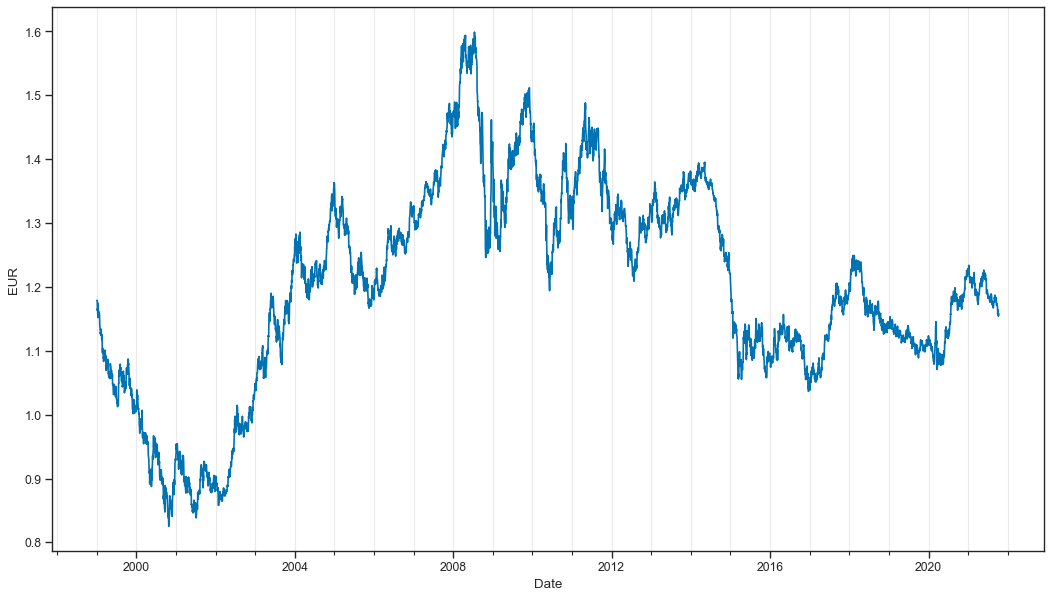

In [9]:
sns.lineplot(x=df['Date'],y=df['EUR'])

### 1.2 Разбивка датасета на обучающую и тренировочную выборки

Перед разбивкой датасета на основании столбца получим более удобную величину чем даты - столбец с номером даты. Так как датасет ежедневные наблюдения, то проблем при обучении возникнуть не должно.

In [10]:
# df['time'] = np.arange(len(df['Date']))
# df.head()

In [11]:
# df['lag_1'] = df['EUR'].shift(1)
# df.head()

Произведём стандартизацию данных.

In [12]:
df.loc[:,'EUR'] = (df['EUR'] - df['EUR'].mean()) / df['EUR'].std()

Разбивка датасета на тренировочную и тестовую выборки

In [13]:
border_line = int(len(df)*0.8)

data_train, data_test = df.iloc[:border_line], df.iloc[border_line:]
data_test.index = np.arange(len(data_test))

## 2 Выбор значения глубины прогноза

In [14]:
TAU_LIST = [2,7,14,30,60]

## 3 Выбор структуры ИНС

In [15]:
class NN:
    def __init__(self,nn_shape):
        self.nn_shape = nn_shape
        self.layers = []
        self.weights = []
        self.bias = []
        self.dw = []
        self.db = []
        self.vw = []
        self.vb = []
        self.RHO = 0.90
        
        for layer_n in range(len(nn_shape)):
            self.layers.append(np.zeros(nn_shape[layer_n],dtype=np.float64))
            if layer_n!=0:
                self.weights.append(np.random.normal(size=(nn_shape[layer_n-1],nn_shape[layer_n])))
                self.bias.append(np.random.normal(size=nn_shape[layer_n]))
                
                # массивы для значений градиентов
                self.dw.append(np.zeros((nn_shape[layer_n-1],nn_shape[layer_n]),dtype = np.float64)) 
                self.db.append(np.zeros(nn_shape[layer_n],dtype = np.float64))

        self.vw = deepcopy(self.weights)
        self.vb = deepcopy(self.bias)
                    
    def sigmoid(self,x):
        return 1/(1 + np.exp(-x))
    
    def forward(self,x):
        for i in range(len(self.layers)):
            if i== 0:
                self.layers[i]=x
            else:
                self.layers[i]=self.sigmoid(x+self.bias[i-1])
            if i!= len(self.layers)-1:
                x = np.dot(self.weights[i].T,self.layers[i])
#                 x = self.weights[i].T@self.layers[i]
                
        return self.sigmoid(x + self.bias[-1])
    
    def back_propagation(self,y,lr=10e-4*5,weight_decay=0.0005):
        # вычисляем градиенты для weights
        for L in range(1,len(self.layers)):
            for i in range(len(self.layers[-L])):
                for j in range(len(self.layers[-L-1])):
                    if L == 1:
                        # dw
                        try:
                            dE_w = (self.layers[-L][i]-y[i])
                        except IndexError:
                            dE_w = (self.layers[-L][i]-y)
                        da_w = self.layers[-L][i]*(1-self.layers[-L][i])                                              
                        dz_w = self.layers[-L-1][j]
                        

                    else:
                        # dw
                        dE_w = np.dot(self.dw[-L+1][i,:],self.weights[-L+1][i,:])
                        da_w = self.layers[-L][i]*(1-self.layers[-L][i])
                        try:
                            dz_w = self.layers[-L-1][j]
                        except KeyError:
                            dz_w = self.layers[-L-1]
                    self.dw[-L][j,i] = dE_w*da_w*dz_w         
        
         # вычисляем градиенты для bias  
        for L in range(1,len(self.db)+1):
            for i in range(len(self.db[-L])):
                if L!=1:
                    dE_b = np.dot(self.weights[-L+1][i],self.db[-L+1])
                    da_b = self.layers[-L][i]*(1-self.layers[-L][i])
                    dz_b = 1
                        
                else:
#                     dE_b = self.layers[-L][i]*(self.layers[-L+1][i]-y[i])
                    try:
                        dE_b = (self.layers[-L+1][i]-y[i])
                    except IndexError:
                        dE_b = (self.layers[-L+1][i]-y)
                    da_b = self.layers[-L+1][i]*(1-self.layers[-L+1][i])
                    dz_b = 1
                    
                self.db[-L][i] = dE_b*da_b*dz_b
                
        # применяем градиенты к weights        
        for L in range(len(self.dw)):
            self.vw[L] = self.RHO * self.vw[L] + self.dw[L] + weight_decay * self.weights[L]
            self.weights[L]-=lr * self.vw[L]
        
        # применяем градиенты к bias
        for L in range(len(self.db)):
#             self.vb[L] = self.RHO * self.vb[L] + self.db[L] + weight_decay * self.bias[L]
#             self.bias[L] -= lr * self.vb[L]
            self.bias[L] -= lr * self.db[L]
    
    def __repr__(self):
        return f'NN({self.nn_shape})'


## Обучение

In [16]:
def train(model,X_train,epochs=1,tau = 2,X_val=None):
    train_loss_history = []
#     validation_accuracy_history = []
    for i in range(epochs):
        running_loss = 0
        for i in range(len(X_train)//tau - 1):
            X_pred = net.forward(X_train[i*tau:i*tau+tau])
            running_loss += np.sum(np.square(X_pred-X_train[i*tau+tau]))/2
            net.back_propagation(X_train[i*tau+tau])
        epoch_loss = running_loss/len(X_train)
        train_loss_history.append(epoch_loss)
    return train_loss_history
#         print("train loss: {train_loss:.4f}".format(train_loss = epoch_loss))

#     return train_loss_history, validation_accuracy_history

In [17]:
tau_current_experiment = 2
net = NN((tau_current_experiment,6,6,1))

train_loss = train(net,data_train['EUR'].to_numpy(),epochs=10)

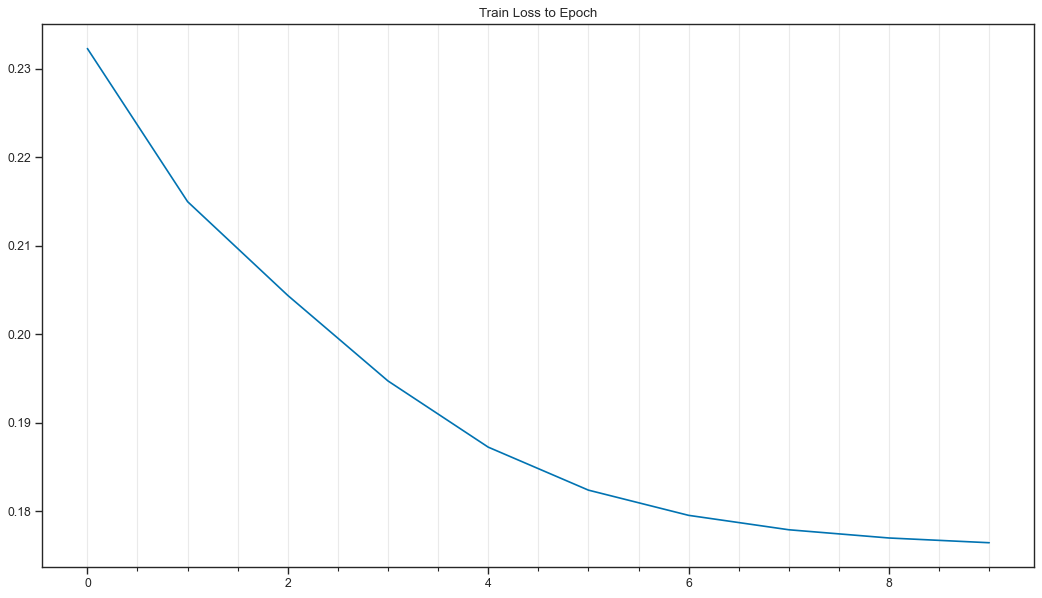

In [18]:
plt.plot(train_loss)
plt.title("Train Loss to Epoch")
plt.show()

In [19]:
data_train.loc[:3,'EUR']

0   -0.129132
1   -0.128506
2   -0.157947
3   -0.227479
Name: EUR, dtype: float64

## Тест предсказаний

In [20]:
# tau_current_experiment
eur_pred_list = []
date_list = []
mean_square_error = 0
for ind in range(len(data_test)-tau_current_experiment):
    eur_pred = float(net.forward(data_test.loc[ind:ind+tau_current_experiment-1,'EUR'].to_numpy()))
    mean_square_error += (data_test.loc[ind+tau_current_experiment-1,'EUR'])**2
    date = data_test.loc[ind+tau_current_experiment-1,'Date']
    eur_pred_list.append(eur_pred)
    date_list.append(date)
    
mean_square_error = mean_square_error / len(eur_pred_list)
print('Среднеквадратичная ошибка:',mean_square_error)

Среднеквадратичная ошибка: 0.14822554553595377


<AxesSubplot:>

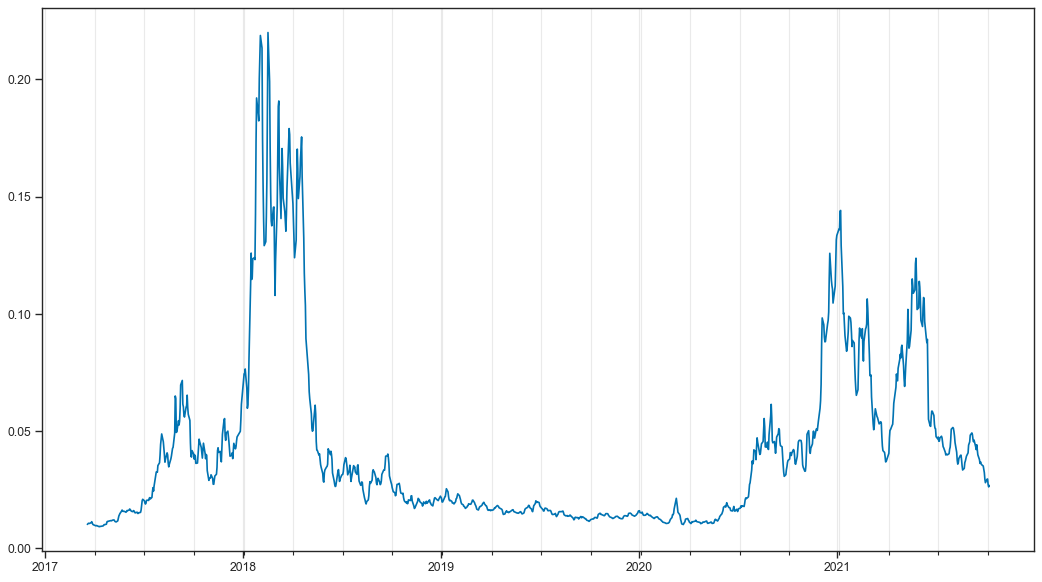

In [21]:
sns.lineplot(x=date_list,y=eur_pred_list)

## Исследование влияния гиперпараметров на точность прогноза

In [49]:
def test_model(model,data_test,tau):
    eur_pred_list = []
    date_list = []
    mean_square_error = 0
    for ind in range(len(data_test)-tau):
        eur_pred = float(model.forward(data_test[ind:ind+tau]))
        mean_square_error += (data_test[ind+tau-1])**2
        eur_pred_list.append(eur_pred)
        date_list.append(date)
        
    mean_square_error = mean_square_error / len(eur_pred_list)
    return mean_square_error

test_model(net,data_test['EUR'].to_numpy(),2)

0.14822554553595377

### Персептрон без скрытых слоёв

In [29]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,1))
        train_loss = train(net,data_train['EUR'].to_numpy(),epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_test['EUR'].to_numpy(),tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())

 17%|██████████████                                                                      | 1/6 [01:22<06:53, 82.60s/it]

2
NN((2, 1))
mean: 0.14822554553595377
std: 0.0


 33%|████████████████████████████                                                        | 2/6 [02:04<03:54, 58.52s/it]

7
NN((7, 1))
mean: 0.14640888772372335
std: 2.7755575615628914e-17


 50%|██████████████████████████████████████████                                          | 3/6 [02:31<02:12, 44.18s/it]

14
NN((14, 1))
mean: 0.14357456086743953
std: 0.0


 67%|████████████████████████████████████████████████████████                            | 4/6 [02:53<01:10, 35.41s/it]

30
NN((30, 1))
mean: 0.13669784226910892
std: 0.0


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [03:15<00:30, 30.61s/it]

60
NN((60, 1))
mean: 0.13170613951644877
std: 0.0


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:32<00:00, 35.40s/it]

365
NN((365, 1))
mean: 0.16410990705184525
std: 0.0


### Персептрон с одним скрытым слоем

In [30]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,int(3/2*tau_current_experiment),1))
        train_loss = train(net,data_train['EUR'].to_numpy(),epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_test['EUR'].to_numpy(),tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())

 17%|█████████████▊                                                                     | 1/6 [03:09<15:47, 189.40s/it]

2
NN((2, 3, 1))
mean: 0.14822554553595377
std: 0.0


 33%|███████████████████████████▋                                                       | 2/6 [06:12<12:23, 185.82s/it]

7
NN((7, 10, 1))
mean: 0.14640888772372335
std: 2.7755575615628914e-17


 50%|█████████████████████████████████████████▌                                         | 3/6 [10:28<10:52, 217.56s/it]

14
NN((14, 21, 1))
mean: 0.14357456086743953
std: 0.0


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [21:01<12:43, 381.91s/it]

30
NN((30, 45, 1))
mean: 0.13669784226910892
std: 0.0


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [36:20<09:35, 575.37s/it]

60
NN((60, 90, 1))
mean: 0.13170613951644877
std: 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [1:51:54<00:00, 1119.13s/it]

365
NN((365, 547, 1))
mean: 0.16410990705184525
std: 0.0


### Персептрон с двумя скрытыми слоями

In [31]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,int(3/2*tau_current_experiment),tau_current_experiment,1))
        train_loss = train(net,data_train['EUR'].to_numpy(),epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_test['EUR'].to_numpy(),tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())

 17%|█████████████▊                                                                     | 1/6 [04:12<21:01, 252.35s/it]

2
NN((2, 3, 2, 1))
mean: 0.14822554553595377
std: 0.0


 33%|███████████████████████████▋                                                       | 2/6 [09:16<18:51, 282.85s/it]

7
NN((7, 10, 7, 1))
mean: 0.14640888772372335
std: 2.7755575615628914e-17


 50%|█████████████████████████████████████████▌                                         | 3/6 [19:13<21:18, 426.05s/it]

14
NN((14, 21, 14, 1))
mean: 0.14357456086743953
std: 0.0


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [37:47<23:15, 697.99s/it]

30
NN((30, 45, 30, 1))
mean: 0.13669784226910892
std: 0.0


 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [1:06:46<17:53, 1073.27s/it]

60
NN((60, 90, 60, 1))
mean: 0.13170613951644877
std: 0.0


 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [2:28:52<29:46, 1786.41s/it]


KeyboardInterrupt: 

## Ряд разностей

In [41]:
data_sub = (df['EUR'] - df['EUR'].shift(1)).to_numpy()
data_sub[0] = 0

In [44]:
border_line = int(len(df)*0.8)

data_sub_train, data_sub_test = data_sub[:border_line], data_sub[border_line:]

### Персептрон без скрытых слоёв

In [50]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,1))
        train_loss = train(net,data_sub_train,epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_sub_test,tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())

 17%|██████████████                                                                      | 1/6 [01:24<07:01, 84.23s/it]

2
NN((2, 1))
mean: 0.0009002116880311064
std: 1.0842021724855044e-19


 33%|████████████████████████████                                                        | 2/6 [02:00<03:44, 56.15s/it]

7
NN((7, 1))
mean: 0.0009028903761678333
std: 1.0842021724855044e-19


 50%|██████████████████████████████████████████                                          | 3/6 [02:22<02:01, 40.48s/it]

14
NN((14, 1))
mean: 0.0009003695625279687
std: 0.0


 67%|████████████████████████████████████████████████████████                            | 4/6 [02:41<01:04, 32.06s/it]

30
NN((30, 1))
mean: 0.0008988476035016148
std: 1.0842021724855044e-19


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:55<00:25, 25.56s/it]

60
NN((60, 1))
mean: 0.0009074141251323331
std: 2.168404344971009e-19


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:06<00:00, 31.02s/it]

365
NN((365, 1))
mean: 0.0007958186575561311
std: 1.0842021724855044e-19


### Персептрон с одним скрытым слоем

In [ ]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,int(3/2*tau_current_experiment),1))
        train_loss = train(net,data_sub_train,epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_sub_test,tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())

 17%|█████████████▊                                                                     | 1/6 [02:31<12:35, 151.08s/it]

2
NN((2, 3, 1))
mean: 0.0009002116880311064
std: 1.0842021724855044e-19


 33%|███████████████████████████▋                                                       | 2/6 [04:54<09:45, 146.46s/it]

7
NN((7, 10, 1))
mean: 0.0009028903761678333
std: 1.0842021724855044e-19


 50%|█████████████████████████████████████████▌                                         | 3/6 [09:05<09:43, 194.50s/it]

14
NN((14, 21, 1))
mean: 0.0009003695625279687
std: 0.0


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [16:29<09:45, 292.92s/it]

30
NN((30, 45, 1))
mean: 0.0008988476035016148
std: 1.0842021724855044e-19


### Персептрон с двумя скрытыми слоями

In [ ]:
ITERATIONS = 10

for tau_current_experiment in tqdm(TAU_LIST):
    mse = np.array([])
    for iteration in range(ITERATIONS):
        net = NN((tau_current_experiment,int(3/2*tau_current_experiment),tau_current_experiment,1))
        train_loss = train(net,data_sub_train,epochs=10,tau=tau_current_experiment)
        mse_current = test_model(net,data_sub_test,tau_current_experiment)
        mse = np.hstack((mse,mse_current))
    print(tau_current_experiment)
    print(net)
    print('mean:',mse.mean())
    print('std:',mse.std())